In [1]:
%matplotlib inline
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbtf
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from djPyi2 import pandas_methods as pm


from djPyi2 import Common as CM

pd.set_option('display.max_columns', 500)
from __future__ import division
from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})

In [2]:
dy_name = 'Figures_SV_Discovery'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)

# Data

In [3]:
# data via "sample_info_combined.ipynb"
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

# data via ipscore_sample_info.ipynb
ipscore_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ipscore_sample_info/ipscore_info.pkl')

# iPSC samples are redundant with Fibroblast samples in HipSci- select the non-iPSC
tdf = sample_info[sample_info.CELL_TYPE != 'iPSC']

# silence slice warnings with copy
tdf = copy.deepcopy(tdf)

tdf.sort_values('age_rank', inplace=True)

# family sizes iPSCORE
f_df =  ipscore_info['iPSCORE_FAMID'].value_counts().to_frame()

gdf = tdf.groupby('SEX')['AGE-RANGE'].value_counts().to_frame(name = 'frequency').reset_index()
gdf2 =  tdf.groupby(['SEX', 'STUDY'])['AGE-RANGE'].value_counts().to_frame(name = 'frequency').reset_index()

In [5]:
picard = '/frazer01/projects/hipsci/pipeline/WGS/MELT_V2/coverage_all.txt'

dfcov = pd.read_table(picard, names=['ID', 'ref', 'coverage'])

dfcov['WGS_ID'] = dfcov.ID.apply(lambda x: x.split('.')[0])

sample_info = sample_info.join(dfcov.set_index('WGS_ID')[['coverage']])

In [32]:
def collection(x):
    try: 
        x.split('.')[1]
        return 'iPSCORE'
    except:
        return 'HipSci'

dfcov['collection'] = dfcov.ID.apply(lambda x: collection(x))

dfcov['coverage'] = dfcov.coverage.astype(int)

In [49]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.2
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['ytick.major.pad'] = 1
mpl.gridspec.rcParams['xtick.major.pad'] = 1
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 8
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'
mpl.gridspec.rcParams['grid.linewidth'] = 0.5

mpl.gridspec.rcParams['font.size'] = 7
mpl.gridspec.rcParams['hatch.linewidth'] = 0.2

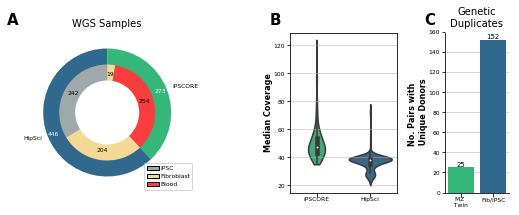

In [63]:
fig =plt.figure(figsize=(7,3),  facecolor='white')
gs = mpl.gridspec.GridSpec(1, 3, hspace=0.6, wspace=0.6, width_ratios=[2,1,0.6])
# ax1 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])




tdf = sample_info[sample_info.STUDY !='HLI']
labels_outer = tdf['STUDY'].value_counts().keys().tolist()
sizes = tdf['STUDY'].value_counts().tolist()
colors_outer = sns.color_palette('viridis', n_colors=len(labels_outer))
pal_study = {'HipSci': colors_outer[0], 'iPSCORE': colors_outer[1]}

ax = ax1
patches, texts, autotext = ax.pie(sizes, labels= labels_outer, startangle=90, pctdistance=0.9, colors=colors_outer, autopct='%s')

for ind, i in enumerate(autotext):
    i.set_text(sizes[ind])
    i.set_size(6)
    i.set_color('w')

for ind, i in enumerate(texts):
    i.set_size(6)

df = tdf.groupby('STUDY').CELL_TYPE.value_counts().to_frame('counts').reset_index()
sizes = df['counts'].tolist()
labels = df.CELL_TYPE.tolist()

unique_labs = list(set(labels))
colorpal = sns.color_palette('Blues', n_colors=len(unique_labs))
colorpal = ['#9fa8ab', '#f4d895','#f93c3c']

colorsDict = dict(zip(unique_labs, colorpal))
colors = [colorsDict[i] for i in labels]

patches, texts, autotext = ax.pie(sizes, colors=colors, radius=0.75, startangle=90, autopct='%s', pctdistance=0.8)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
ax.add_artist(centre_circle)

for ind, i in enumerate(autotext):
    i.set_text(sizes[ind])
    i.set_size(6)
    i.set_color('black')

for ind, i in enumerate(texts):
    i.set_size(6)
    
patches = mpltools.get_legend_patches(unique_labs, rectfacecolor=colorpal, just_rect=True)
ax.legend(handles = patches, fontsize = 6, bbox_to_anchor = [1.05,0], loc = 'lower right')






ax = ax2
ax.yaxis.grid(zorder = 0)
sns.violinplot(x = 'collection', y = 'coverage', data = dfcov, cut = 0, ax = ax2, 
               palette= pal_study, zorder = 20)
ax.set_ylabel('Median Coverage')
ax.set_xlabel('')

ax = ax3 
ax.yaxis.grid(zorder = 0)
ax.bar(1, 25, color = pal_study['iPSCORE'], zorder = 20)
ax.text(1, 26, 25, ha = 'center')
ax.bar(2, 152, color = pal_study['HipSci'], zorder = 20)
ax.text(2, 153, 152, ha = 'center')
sns.despine(ax = ax)
ax.set_xticklabels(['','MZ \n Twin ', 'Fib/iPSC'])
ax.set_ylabel('No. Pairs with \n Unique Donors')
ax.set_title('Genetic\nDuplicates')

gs.tight_layout(fig)
ax = ax1
p = ax.get_position()
h_in = fig.get_figheight()
w_in = fig.get_figwidth()
aspect= h_in/w_in
new_width = p.height * aspect

ax.set_position([p.x0, p.y0, new_width, p.height])
ax.set_title('WGS Samples')




labels = ['A', 'B', 'C']
for i, a in enumerate([ax1, ax2, ax3]):
    mpltools.label_offset_axes(a, fig, labels[i],
                               x = -20, y = 8)

out_fn = private_out + '/Figure_WGS_Information'
fig.savefig(out_fn, bbox_inches='tight', dpi = 200)

# a_w = p.width * w_in
# a_h = p.height * h_in


# Data Supplement

In [72]:
# data via "sample_info_combined.ipynb"
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

# data via ipscore_sample_info.ipynb
ipscore_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ipscore_sample_info/ipscore_info.pkl')

# iPSC samples are redundant with Fibroblast samples in HipSci- select the non-iPSC
tdf = sample_info[(sample_info.CELL_TYPE != 'iPSC')  & 
                  (sample_info.STUDY != 'HLI')]

# silence slice warnings with copy
tdf = copy.deepcopy(tdf)

tdf.sort_values('age_rank', inplace=True)

# family sizes iPSCORE
f_df =  ipscore_info['iPSCORE_FAMID'].value_counts().to_frame()

gdf = tdf.groupby('SEX')['AGE-RANGE'].value_counts().to_frame(name = 'frequency').reset_index()
gdf2 =  tdf.groupby(['SEX', 'STUDY'])['AGE-RANGE'].value_counts().to_frame(name = 'frequency').reset_index()

# Supplemental Figure

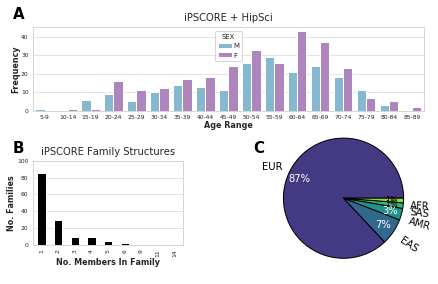

In [86]:
with sns.axes_style('whitegrid'):
    fig =plt.figure(figsize=(7,4),  facecolor='white')
    gs = mpl.gridspec.GridSpec(2, 2, hspace=0.6, wspace=0.6,
                               width_ratios=[1,1])


    ax1 = fig.add_subplot(gs[0, :])

    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    ax = ax1
    pal = {'F': (0.7058823529411765, 0.48627450980392156, 0.7803921568627451),
           'M': (0.4666666666666667, 0.7450980392156863, 0.8588235294117647)}

    labels = tdf['AGE-RANGE'].unique()
    indexes = tdf['age_rank'].unique()
    ticklabels = [labels[i-1] for i in indexes]
    sns.barplot(x = 'AGE-RANGE', y= 'frequency', hue = 'SEX', 
                hue_order=['M', 'F'], order=ticklabels, 
                data=gdf, ax = ax,palette= pal)
    #     ax.set_xticklabels(ticklabels)
    ax.set_xlabel('Age Range')
    ax.set_ylabel('Frequency')
    ax.set_title('iPSCORE + HipSci')


    ax = ax2

    f_df.iPSCORE_FAMID.value_counts().sort_index().plot(kind='bar', ax=ax, color= 'black')
    ax.set_xlabel('No. Members In Family')
    ax.set_ylabel('No. Families')
    ax.grid(axis='x')
    ax.set_yticks(np.arange(0, 110, 20))

    ax.set_title('iPSCORE Family Structures')

ax = ax3
labels =tdf['GENETICALLY_SIMILAR_POPULATION_GROUP'].value_counts().keys()
sizes = tdf['GENETICALLY_SIMILAR_POPULATION_GROUP'].value_counts()
colors = sns.color_palette('viridis', n_colors=len(labels))
#     explode = [0.12, 0.12, 0.12, 0.12, 0.12, 0.12]
    
patches, texts, autotext= ax.pie(sizes, 
                                 labels= labels, pctdistance=0.8,
                           autopct='%.0f%%', colors = colors, rotatelabels=True)


for patch in patches:
    patch.set_edgecolor('black')
    
    
for t in texts:
    t.set_size(10)

t = texts[0]
t.set_rotation(0)



for i in autotext[0:3]:
    i.set_size(10)
    i.set_color('w')

for i in autotext[3:]:
    i.set_size(8)
    i.set_color('black')



fig.canvas.draw()

labels = ['A', 'B', 'C']
for i, a in enumerate([ax1, ax2, ax3]):
    mpltools.label_offset_axes(a, fig, labels[i],
                               x = -20, y = 8)

p = ax.get_position()
h_in = fig.get_figheight()
w_in = fig.get_figwidth()
aspect= w_in/h_in
new_height = p.width * aspect

ax.set_position([p.x0 -0.01, p.y0 - 0.1, p.width, new_height])

out_fn = private_out + '/SuppFig_Subject_Info'
fig.savefig(out_fn, bbox_inches='tight', dpi = 200)

In [12]:
fig =plt.figure(figsize=(12,4),  facecolor='white')
gs = mpl.gridspec.GridSpec(1, 3, hspace=0.6, wspace=0.6, width_ratios=[1,1,0.6])
# ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[0,2])


f_df.iPSCORE_FAMID.value_counts().sort_index().plot(kind='bar', ax=ax2, color= 'black')
ax2.set_xlabel('No. Members In Family')
ax2.set_ylabel('No. Families')



pal = {'F': (0.7058823529411765, 0.48627450980392156, 0.7803921568627451),
       'M': (0.4666666666666667, 0.7450980392156863, 0.8588235294117647)}

sns.barplot(x = 'AGE-RANGE', y= 'frequency', hue = 'SEX', hue_order=['M', 'F'], order=ticklabels, data=gdf, ax = ax1, palette= pal)
#     ax.set_xticklabels(ticklabels)
ax1.set_xlabel('AGE-RANGE')
ax1.set_ylabel('frequency')
ax1.set_title('i2QTL (iPSCORE + HipSci)')
ax1.tick_params(axis = 'x', labelrotation=45)
pal_study = {'HipSci': colors_outer[0], 'iPSCORE': colors_outer[1]}
sns.violinplot(x = 'collection', y = 'coverage', data = dfcov, cut = 0, ax = ax3, palette= pal_study)

3.02

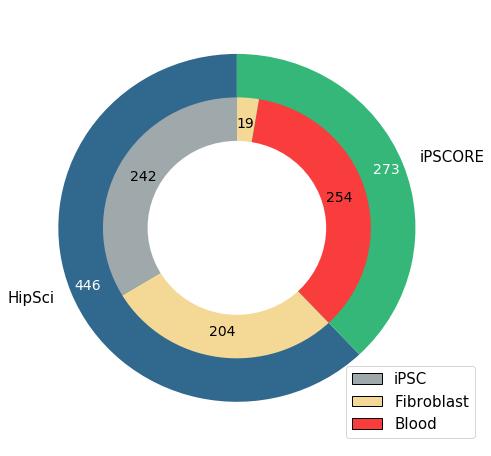

In [4]:
fig, ax = plt.subplots(1,1, figsize = (8,8), facecolor = 'white')

tdf = sample_info[sample_info.STUDY !='HLI']
labels = tdf['STUDY'].value_counts().keys().tolist()
sizes = tdf['STUDY'].value_counts().tolist()
colors = sns.color_palette('viridis', n_colors=len(labels))


patches, texts, autotext = ax.pie(sizes, labels= labels, startangle=90, pctdistance=0.9, colors=colors, autopct='%s')

for ind, i in enumerate(autotext):
    i.set_text(sizes[ind])
    i.set_size(14)
    i.set_color('w')

for ind, i in enumerate(texts):
    i.set_size(15)

df = tdf.groupby('STUDY').CELL_TYPE.value_counts().to_frame('counts').reset_index()
sizes = df['counts'].tolist()
labels = df.CELL_TYPE.tolist()

unique_labs = list(set(labels))
colorpal = sns.color_palette('Blues', n_colors=len(unique_labs))
colorpal = ['#9fa8ab', '#f4d895','#f93c3c']

colorsDict = dict(zip(unique_labs, colorpal))
colors = [colorsDict[i] for i in labels]

patches, texts, autotext = ax.pie(sizes, colors=colors, radius=0.75, startangle=90, autopct='%s', pctdistance=0.8)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

for ind, i in enumerate(autotext):
    i.set_text(sizes[ind])
    i.set_size(14)
    i.set_color('black')

for ind, i in enumerate(texts):
    i.set_size(12)
    
patches = mpltools.get_legend_patches(unique_labs, rectfacecolor=colorpal, just_rect=True)
ax.legend(handles = patches, fontsize = 15, bbox_to_anchor = [1.05,0], loc = 'lower right')
